In [2]:
import numpy  as np
import spglib as spg
import matplotlib.pyplot as plt
import hyperspy.api as hs
from EELS import system, spectrum
from matplotlib import colors
from scipy import signal

folder = "./"

# Define cells and symmetry
For parabolic bands, use a cubic symmetry

In [3]:
lattice = np.array([[ 3.2871687359128612, 0.0000000000000000, 0.0000000000000000],
                    [-1.6435843679564306, 2.8467716318265182, 0.0000000000000000],
                    [ 0.0000000000000000, 0.0000000000000000, 5.3045771064003047]])

positions = [[0.3333333333333357,  0.6666666666666643,  0.9996814330926364],
             [0.6666666666666643,  0.3333333333333357,  0.4996814330926362],
             [0.3333333333333357,  0.6666666666666643,  0.3787615522102606],
             [0.6666666666666643,  0.3333333333333357,  0.8787615522102604]]

numbers = [30, 30, 8, 8]

cell= (lattice, positions, numbers)
sym = spg.get_symmetry(cell, symprec=1e-5)
print(spg.get_spacegroup(cell, symprec=1e-5))

P6_3mc (186)


In [13]:
mesh = np.array([3,3,3]) # use odd numbers

In [14]:
mapping, grid = spg.get_ir_reciprocal_mesh(mesh, cell, is_shift=[0, 0, 0])
grid.shape

(27, 3)

In [19]:
occurences = np.bincount(mapping)[np.unique(mapping)]

grid_ir = grid/(mesh-1)
grid_ir = grid_ir[np.unique(mapping)]
mapping_ir = mapping[np.unique(mapping)]
for i in range(len(mapping_ir)):
    print("occ = ",occurences[i], "\t irr = ",grid_ir[i])

grid_ir

occ =  1 	 irr =  [ 0.  0.  0.]
occ =  6 	 irr =  [ 0.5  0.   0. ]
occ =  2 	 irr =  [ 0.5  0.5  0. ]
occ =  2 	 irr =  [ 0.   0.   0.5]
occ =  12 	 irr =  [ 0.5  0.   0.5]
occ =  4 	 irr =  [ 0.5  0.5  0.5]


array([[ 0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0. ],
       [ 0.5,  0.5,  0. ],
       [ 0. ,  0. ,  0.5],
       [ 0.5,  0. ,  0.5],
       [ 0.5,  0.5,  0.5]])

In [31]:
last = np.zeros(3)
for point in grid_ir[1:]:
    last=point
    

50.0
50.0
86.6025403784
50.0
50.0


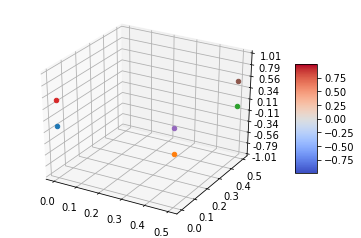

In [22]:
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.



# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Generate energies, waves and k-list

In [6]:
def gauss(sigma, eRange):
    dE = eRange[1]-eRange[0]
    gx = np.arange(-3*sigma,3*sigma, dE)
    gaussian = np.exp(-0.5*(gx/sigma)**2)
    gaussian = gaussian/np.sum(gaussian)
    
    gauss =np.zeros((len(gaussian),1,1,1))
    gauss[:,0,0,0] = gaussian
    return gauss

def smooth(hist, eRange, sigma):
    gaussian = gauss(sigma, eRange)
    
    crop_front = len(gaussian)//2
    if len(gaussian)%2 == 1:
        crop_end = crop_front
    else:
        crop_end = crop_front-1
        
    return signal.convolve(hist, gaussian)[crop_front:-crop_end]

In [7]:
_hbar = 1973 #eV AA
_me = .511e6 #eV

def band(k_vec, E0, m, k_center):
    band = E0+(_hbar**2/(2*_me))*((k_vec[:,0]-k_center[0])**2/m[0]\
               +(k_vec[:,1]-k_center[1])**2/m[1]\
               +(k_vec[:,2]-k_center[2])**2/m[2])
    return band

In [8]:
sigma = 0.0649/2.3548
sigma

0.027560727025649736

In [9]:
wave = np.array([0, 1])
band_gap = 3.3



def runSeries(root, fermiEnergies):
    
    eBin = np.linspace(3,5,120)

    """
    coordinates = [[  0.0,   0.0,   0.0], [  0.0,    0.0,   0.0], [  0.0,    0.0,   0.0], [  0.0,   0.0,   0.0]]
    eff_masses  = [[-2.55, -2.55, -0.27], [-2.45,  -2.45, -2.45], [-0.34,  -0.34, -2.47], [ 0.29,  0.29,  0.25]]
    energy_offset =  [0.0, 0.0, 0.0, band_gap]
    """
    
    coordinates = [[  0.0,   0.0,   0.0], [  0.0,   0.0,   0.0]]
    eff_masses  = [[-0.34,  -0.34, -0.27], [ 0.29,  0.29,  0.25]]
    energy_offset =  [0.0, band_gap]
    
    
    
    k_list = []
    bands = []
    for i in range(len(coordinates)):
        bands.append((coordinates[i],eff_masses[i],energy_offset[i]))

    k_arr = np.zeros((len(np.unique(mapping)),len(grid[0])))
    e_arr = np.zeros((len(np.unique(mapping)),len(bands),))
    w_arr = np.zeros((len(np.unique(mapping)),len(bands),len(wave)))

    for i, map_id in enumerate(mapping[np.unique(mapping)]):
        k_list.append((grid[mapping==map_id]/(mesh-1)).tolist())
        k_arr[i] = grid[map_id]/(mesh-1)


    for i, band_info in enumerate(bands):
        e_arr[:,i] = band(k_arr, band_info[2], band_info[1], band_info[0])
        w_arr[:,i] = np.outer(wave,np.ones(len(k_arr))).T


    k = np.linspace(-0.5,0.5,100)
    k = np.stack([k,np.zeros(len(k)),np.zeros(len(k))],axis=1)


    """plt.xlabel('k_x')
    plt.ylabel('Energy')
    old_band = 0
    test = []
    for i, band_info in enumerate(bands):
        band_energies = band(k, band_info[2], band_info[1], band_info[0])
        test.append(band_energies)
        plt.plot(k[:,0],band_energies)
        old_band = band_energies
    plt.plot([-0.5,0.5],[fermiEnergy,fermiEnergy],'--')
    plt.show()"""



    folder = root
    for fermiEnergy in fermiEnergies:
        model = "Parabolic"
        name = "Scleife 4 bands fermi {}".format(fermiEnergy)
        title = "Fermi {}".format(fermiEnergy)
        notes = "Based on Schleife 2009, Bands: G7c, G7+v, G7v, G7-v"
        meta = spectrum.createMeta(name=name, title=title, authors="Sindre R. Bilden", notes=notes, model=model, cell=lattice, fermi=fermiEnergy, coordinates=coordinates, effective_masses=eff_masses, energy_levels=energy_offset)


        
        EELS = spectrum.calculate_spectrum((mesh,k_list,e_arr,w_arr),eBin,fermiEnergy)

        signal = spectrum.createSignal(data=EELS,eBin=eBin,mesh=mesh,metadata=meta)
        signal_smooth = spectrum.createSignal(data=smooth(EELS, eBin, sigma),eBin=eBin,mesh=mesh,metadata=meta)


        spectrum.saveHyperspy(signal, filename='../Results/%s/fermi_%.2f' %(folder,fermiEnergy-band_gap))
        spectrum.saveHyperspy(signal_smooth, filename='../Results/%s/smoothed/fermi_%.2f' %(folder,fermiEnergy-band_gap))

In [11]:
fermi = [3.485]

runSeries("Schleife2009/unreal_valence/51/", fermi)

In [ ]:
EELS_smooth = smooth(EELS, eBin, 0.02) #smoothing of data